<a href="https://colab.research.google.com/github/nattapongbam/229352-StatisticalLearning681/blob/main/Copy_of_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [2]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [4]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset), # ใส่ทั้งก้อน เพราะข้อมูลมันเล็ก ไม่เหมือน train_loader
                        shuffle=False)

#### Do the same for the test images

In [7]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [8]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

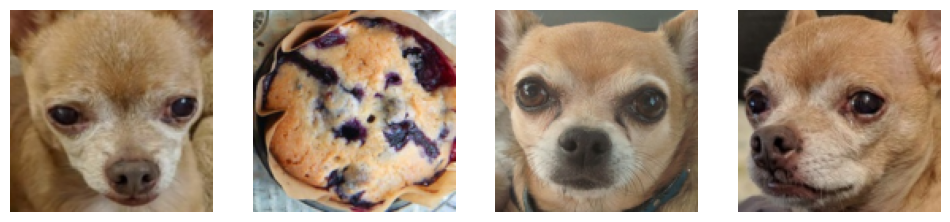

tensor([0, 1, 0, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self): #attributs are layers
        super().__init__() # call all attribuit in parent class (SimpleLogisticRegression, self)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(128 * 128 * 3, 100) # เลข 100 คือขนาดที่เราจะให้มันเป็น (จะเอาค่าไหนก็ได้)
        self.ralu1 = nn.ReLU()
        self.lin2 = nn.Linear(100, 50) #มัน input มาจาก layer lin1
        self.ralu2 = nn.ReLU()
        self.lin3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid() # ใน pytorch ไม่ต้องเขียน

    def forward(self, x):
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.ralu1(x)
        x = self.lin2(x)
        x = self.ralu2(x)
        x = self.lin3(x)
        x = self.sigmoid(x)
        return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [10]:
model = SimpleLogisticRegression()
criterion = nn.BCEWithLogitsLoss() #Loss function for classification

#### Manually setting initial weights to zero for demonstration

In [ ]:
# with torch.no_grad():
#   for layer in model.modules():
#       if isinstance(layer, nn.Linear):
#           layer.weight.zero_()
#           layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [11]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [12]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [13]:
x, y = next(iter(train_batches))

In [14]:
y

tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 0])

#### Make a prediction on the minibatch (Forward pass)

In [15]:
y_hat = model(x)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]
# val_loss = criterion(y_hat, y)
# val_losses.append(val_loss.item())

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

In [16]:
y_hat

tensor([0.5215, 0.5256, 0.5148, 0.5165, 0.5205, 0.5210, 0.5268, 0.5188, 0.5212,
        0.5299], grad_fn=<SelectBackward0>)

In [17]:
y

tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 0.])

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [18]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss.item())

In [19]:
train_loss

tensor(0.7797, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

#### Calculate the gradient (Backward pass)

In [20]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [23]:
model.parameters()

<generator object Module.parameters at 0x7c1355b850e0>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [24]:
# Manually update the weights using the gradient descent rule
optimizer.step() # parameters - learning_rate * gradient_of_parameters (gradient_of_parameters = gradient_decent)

# Zero the gradients after updating
model.zero_grad() #set previous gradient to 0

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [25]:
with torch.no_grad():
  for X, y_v in val_loader:
    y_v_hat = model(X)
    y_v_hat = y_v_hat[:, 0]
    y_v = y_v.to(torch.float32)
    val_loss = criterion(y_v_hat, y_v)
    val_losses.append(val_loss.item())

In [26]:
print(train_losses)
print(val_losses)

[0.7796804308891296]
[0.7264917492866516]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

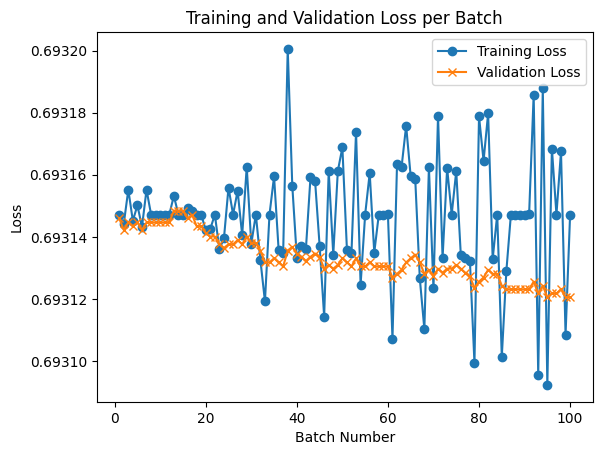

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [13]:
class SimpleLogisticRegression(nn.Module):
    def __init__(self): #attributs are layers
        super().__init__() # call all attribuit in parent class (SimpleLogisticRegression, self)
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(128 * 128 * 3, 64) # เลข 100 คือขนาดที่เราจะให้มันเป็น (จะเอาค่าไหนก็ได้)
        self.ralu1 = nn.ReLU()
        self.lin2 = nn.Linear(64, 32) #มัน input มาจาก layer lin1
        self.ralu2 = nn.ReLU()
        self.lin3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.lin1(x)
        x = self.ralu1(x)
        x = self.lin2(x)
        x = self.ralu2(x)
        x = self.lin3(x)
        x = self.sigmoid(x)
        return x

Learning rate: 0.01
Training loss: 0.6930985450744629
Validation loss: 0.6929590106010437



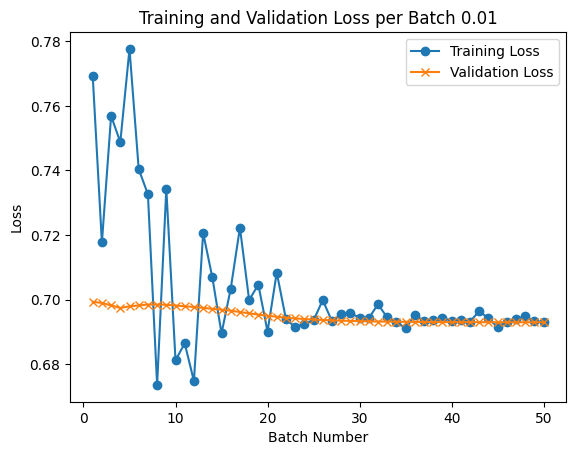

---------------------------------
Learning rate: 0.001
Training loss: 0.7337234020233154
Validation loss: 0.6991739273071289



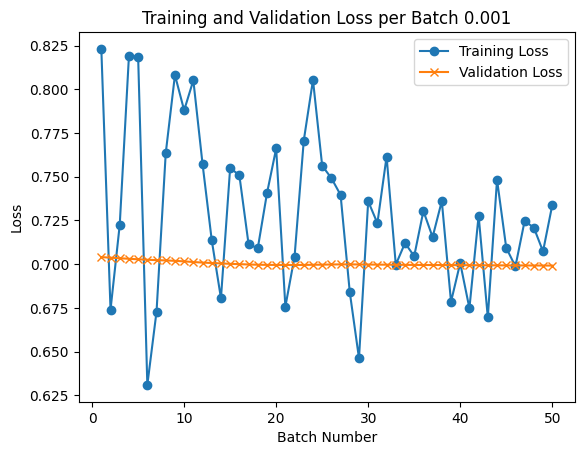

---------------------------------
Learning rate: 0.0001
Training loss: 0.7136203646659851
Validation loss: 0.700989305973053



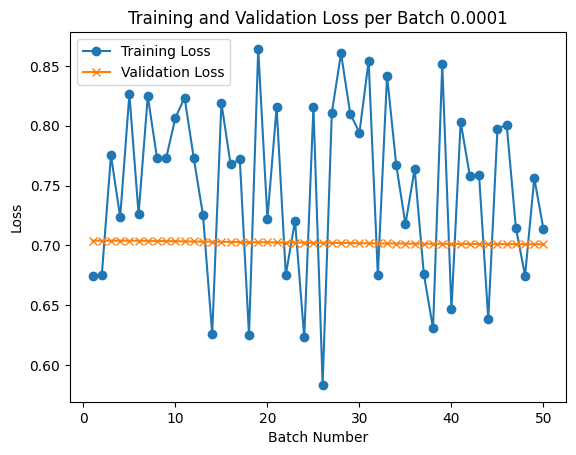

---------------------------------
Learning rate: 1e-05
Training loss: 0.7194694876670837
Validation loss: 0.7001927495002747



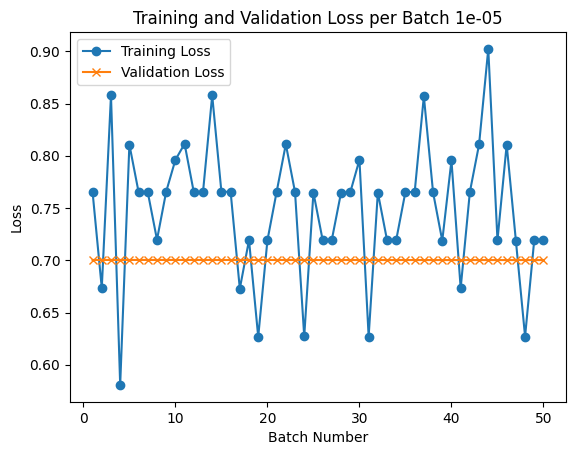

---------------------------------


In [18]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
for lr_rate in learning_rates:
    model = SimpleLogisticRegression()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr_rate, momentum=0.9)
    train_losses = []
    val_losses = []
    for epoch in range(5):
        for x, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for X, y in val_loader:
                    y_hat = model(X)
                    y_hat = y_hat[:, 0]
                    y = y.to(torch.float32)

                    val_loss = criterion(y_hat, y)
                    val_losses.append(val_loss.item())

    print(f'Learning rate: {lr_rate}')
    print(f'Training loss: {train_losses[-1]}')
    print(f'Validation loss: {val_losses[-1]}')
    print()
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
    plt.title(f'Training and Validation Loss per Batch {lr_rate}')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('---------------------------------')

# 2.1 ค่า learning rate ที่ 0.01 มีค่า loss น้อยที่สุดประมาณ 0.69

# 2.2 ถ้าค่า learning rate ใหญ่เกินไปอาจทำให้โมเดลข้ามสุดที่ดีที่สุดไปมา ซึ่งทำให้ค่า loss แกว่งไปมา

# 2.3 ค่า learning rate ที่เล็กเกินไป ทำให้โมเดลเรียนรู้ช้าต้องใช้เวลา train นานกว่าจะถึงค่าต่ำสุด

In [21]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions

  correct = (y_hat == y).sum().item()
  total = len(y)
  accuracy = (correct / total)*100
  print(f"Test accuracy: {accuracy:.2f}%")

Test accuracy: 56.67%


In [ ]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

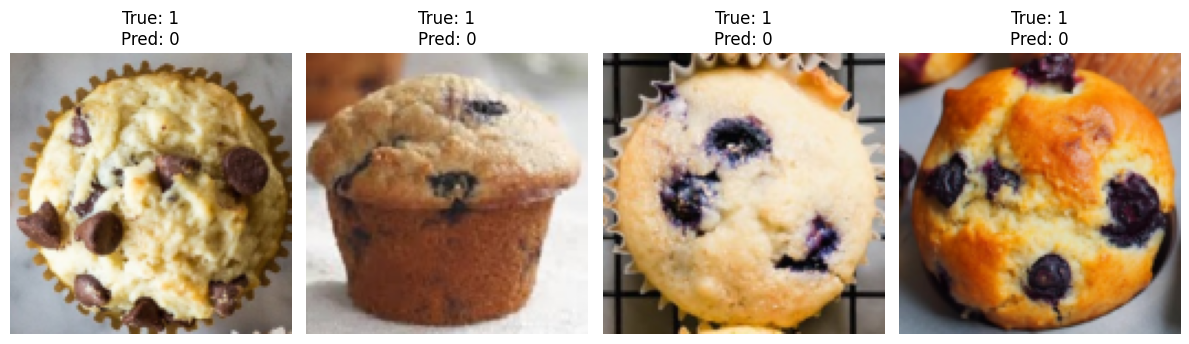

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# เก็บรูปที่ทายผิด
incorrect_images = []
incorrect_labels = []
predicted_labels = []

model.eval() # ตั้งโหมดประเมินผล
with torch.no_grad():
    for X, y in test_loader:
        outputs = model(X)
        y_hat = outputs[:, 0]
        preds = (y_hat > 0.5).float() # ทายว่าเป็น 0 หรือ 1

        # หาดัชนี (Index) ที่ทายไม่ตรงกับความจริง
        mask = (preds != y)

        # ดึงเฉพาะรูปและ Label ที่ผิดออกมา
        wrong_X = X[mask]
        wrong_y = y[mask]
        wrong_preds = preds[mask]

        # สะสมไว้จนกว่าจะครบ 4 รูป
        for i in range(len(wrong_X)):
            if len(incorrect_images) < 4:
                incorrect_images.append(wrong_X[i].cpu())
                incorrect_labels.append(wrong_y[i].cpu())
                predicted_labels.append(wrong_preds[i].cpu())
            else:
                break

        if len(incorrect_images) >= 4:
            break

# --- ส่วนการพล็อต ---
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(1, 4, i + 1)

    # ขยับแกนจาก (C, H, W) เป็น (H, W, C) สำหรับ imshow
    img = incorrect_images[i].numpy().transpose(1, 2, 0)

    # ถ้ามีการ Normalize มาก่อน (เช่น หาร 255) อย่าลืมเช็คค่าให้แสดงผลได้
    plt.imshow(img)
    plt.title(f"True: {int(incorrect_labels[i])}\nPred: {int(predicted_labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()